# PW02 - Group 4
* Florian Bär
* Matthias Egli
* Manuel Vogel
* Adrian Willi

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Linear Regression

Using the rent prices from appartments in Lausanne from PW 02, restricting to the feature living area.

### Load Data

In [2]:
import pandas as pd
df = pd.read_csv("lausanne-appart.csv")
N  = df.shape[0]
df.head()

,living_area,nb_rooms,rent_price
0,69,3.0,1810
1,95,3.5,2945
2,21,1.5,685
3,20,1.0,720
4,33,1.5,830


### Normalization

In [3]:
x0 = df.values[:,0]
x = (x0-np.mean(x0))/np.std(x0)
y0 = df.values[:,2]
y = (y0-np.mean(y0))/np.std(y0)

Text(0, 0.5, 'rent_price')

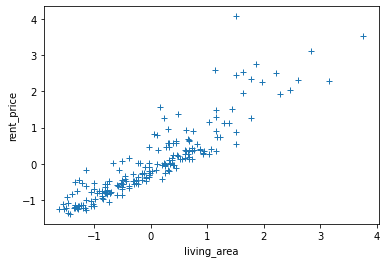

In [4]:
plt.plot(x, y,"+")
plt.xlabel("living_area")
plt.ylabel("rent_price")

### Linear Model, Normal Equations and Solution

We denote the observed rent by $y_j$ (at time $x_j$) and the model rent by $\hat{y}_j$ we assume 

$\qquad \hat{y}_j = \alpha + \beta x_j$

By minimizing the mean squares error

$\qquad C = \frac{1}{2N}\sum_j \left(y_j-\hat{y}_j\right)^2 = C(\alpha,\beta)$

we can fit the straigth line as follows by using the design matrix $X$ and the data vector $Y$, defined by 

$\qquad X = \left(\begin{array}{cc} 1 & x_0 \\ 1 & x_1 \\ \vdots & \vdots \\ 1 & x_{N-1}\end{array}\right), \qquad Y = \left(\begin{array}{c} y_0\\ \vdots \\ y_{N-1}\end{array}\right)$

We find 

$\qquad \left(\begin{array}{c}\alpha \\ \beta\end{array}\right) = \left(X^T\cdot X\right)^{-1}\cdot X^T\cdot Y$

Hence, here we can easily compute the (linear) model which best fits the training data in the sense of obtaining a minimal mean square error. 

### Solution of Normal Equations in Pytorch

'a = torch.lstsq(Y, X).solution[0:2, 0]\nYhat = X@a\nplt.plot(X[:,1],Y,"+")\nplt.plot(X[:,1],Yhat,\'r\')\nplt.xlabel("living_area")\nplt.ylabel("rent_price")'

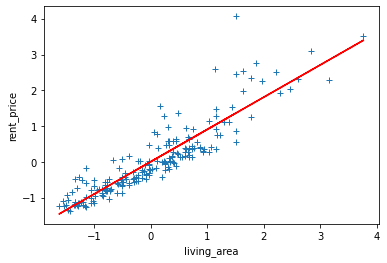

In [5]:
N = x.size

# YOUR CODE (START)
# compose torch tensors X,Y of shape (N,2) and (N,1) respectively
X = torch.cat((torch.ones(N,1), torch.tensor(x).reshape(-1,1)), dim=1)
Y = torch.tensor(y).reshape(-1,1)

# solution of normal equations, 'params' a torch tensor of shape (2,1) that 
# contains parameters alpha and beta, which shall be optimized
a = torch.inverse(X.T@X)@X.T@Y
alpha = a[0]
beta = a[1]

# prediction
Yhat = (alpha + beta*x).reshape(-1,1)

# YOUR CODE (END)

# plot
plt.plot(X[:,1],Y,"+")
plt.plot(X[:,1],Yhat,'r')
plt.xlabel("living_area")
plt.ylabel("rent_price")


"""a = torch.lstsq(Y, X).solution[0:2, 0]
Yhat = X@a
plt.plot(X[:,1],Y,"+")
plt.plot(X[:,1],Yhat,'r')
plt.xlabel("living_area")
plt.ylabel("rent_price")"""

Note that with the pytorch function `torch.lstsq` you can obtain the same.

#### Cost
$\qquad C = \frac{1}{2N}\sum_j \left(y_j-\hat{y}_j\right)^2 = C(\alpha,\beta)$

In [8]:
def cost(X,Y,a):
    # YOUR CODE (START)
    N = len(X)
    x = X[:,1].reshape(-1,1)
    Yhat = (a[0] + a[1]*x)
    return torch.sum(torch.pow(Y-Yhat,2))/(2*N)
    # YOUR CODE (END)

In [9]:
cost_closed_form = cost(X,Y,a)
print(cost_closed_form)

tensor(0.0912, dtype=torch.float64)


### Gradient Descent

Specify the gradient of the cost (w.r.t. $\alpha, \beta$) here as maths expression.

In [10]:
def gradient_cost(X,Y,a):
    # YOUR CODE (START)
    N = len(X)
    x = X[:,1].reshape(-1,1)
    Yhat = (a[0] + a[1]*x)
    pda = torch.sum(-2*(Y - Yhat))/(2*N)
    pdb = torch.sum(-2*x*(Y - Yhat))/(2*N)
    return torch.tensor([[pda], [pdb]])
    # YOUR CODE (END)

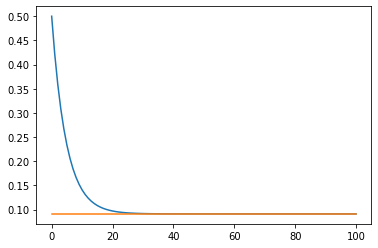

In [77]:
# adjust if needed
nepochs = 100
lr = 0.1

## initial parameter
a = torch.tensor([0.0,0.0], dtype=torch.float64).reshape(2,1)

# track the costs
costs = [cost(X,Y,a)]

# YOUR CODE (START)

# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    a = a - lr * gradient_cost(X,Y,a)
    costs.append(cost(X,Y,a))

# YOUR CODE (END)
    
# some output
cost_gd = costs[-1]
plt.plot(range(nepochs+1),costs)
plt.plot(range(nepochs+1),cost_closed_form*torch.ones(nepochs+1))

### Different Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.

**Initial**: 
* 0.1: Min of ca. 0.1 at around 20 epochs

**Decreasing Learning Rate**:
* 0.05: Min of ca. 0.1 at around 50 epochs
* 0.01: Min of ca. 0.1 is not reached after 100 epochs, we would need to train longer

Decreasing the learning rate further leads to slower trainig, i.e. increasing the number of epochs would be necessary to reach the same result. E.g. with a learning rate of 0.001, we reach the min of 0.1 after 3000 epochs. Since we fix nepochs=100, decreasing the learning rate does not seem reasonable.

**Increasing Learning Rate**: 
* 0.5: Min of ca. 0.1 at around 5 epochs
* 1.0: Min of ca. 0.1 at around 1 epoch, pretty much a straight line down
* 1.5: Looks identical to lr=0.5
* 1.9: Looks identical to lr=0.1
* 2.0: Straight line, similar to lr=0.00001, but does not seem to learn, even after 100000 epochs. In contrast, we see a reduction of the cost with lr=0.00001 after 100000 epochs

A learning rate of 1.9 works if we increase the number of epochs. A learning rate of 2.0 does not seem to work anymore, even after 100'000, we don't see any progress.